# TOMAS Basics

`TOMAS` is a computational framework that derives total mRNA content ratios between cell populations via deconvoluting their heterotypic doublets. 

In this tutorial, we will begin with **a simple scenario involving two cell types** to demonstrate how `TOMAS` works. The general case with multiple cell types could be broken into several two-cell-type cases. For simplicity, we assume the droplet labels are known. 

We utilized a simulation dataset with known ground truth as an illustration, setting the mean of total-mRNA ratios between the two cell types at 4. The Dirichlet-Multinomial probability signatures of the two cell types are derived from our in-house T cell activation dataset. This example dataset is available for [download](https://github.com/QiuyuLian/TOMAS/tree/main/datasets). 

In [1]:
import tomas as tm
import scanpy as sc
import numpy as np
import pandas as pd
import time
from matplotlib import pyplot as plt

In [2]:
adata = sc.read_h5ad('../../datasets/adata_basic.h5ad') # set the path to match how you save the downloaded data.
adata.obs.head(3)  # ground truth of droplet labels and total-mRNA ratios are stroed in adata.obs

,danno,trueR
d_1705,naive,NaN
d_2401,naive,NaN
d_1319,naive,NaN


There are totally 1000 droplets with 50 doublets (doublet rate is 5%) in the simulation dataset.

The label of droplets should be stored in `adata.obs`. The naming of heterotypic doublets must be the concatenation of names of two component cell types by underscore('_'). Avoid undersocre in names of homotypic droplets.

In [3]:
np.unique(adata.obs['danno'],return_counts=True)

(array(['active', 'naive', 'naive_active'], dtype=object),
 array([475, 475,  50]))

Display UMI amount distribution if necessary.

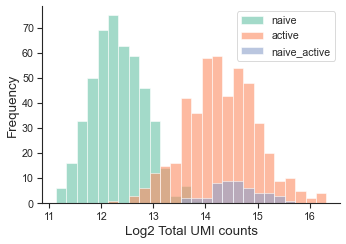

In [4]:
tm.vis.UMI_hist(adata,groupby='danno')

## Step1: Fit Homotypic Droplet Populations 

Fit total UMI amounts with log-Normal distribution. The parameters are stored in `adata.uns['para_logUMI']`.

In [5]:
tm.fit.logNormal(adata,groupby='danno')

Fit gene probability signatures with Dirichlet-Multinomial (DMN) model. The optimizated paremeters `Alpha` of each cell types are stroed in `adata.varm['para_diri']`.

In [6]:
tm.fit.dmn(adata,
           groupby='danno',
           groups=['naive','active'],  
           verbose=2,
           verbose_interval = 100) 

Initialization 0
  Iteration 100	 time lapse 12.34517s	 ll change 0.10193
Initialization converged: True	 time lapse 23.97408s	 ll -163680.93666
active is done!
Initialization 0
  Iteration 100	 time lapse 9.94024s	 ll change 0.06904
  Iteration 200	 time lapse 9.56807s	 ll change 0.00602
  Iteration 300	 time lapse 9.88499s	 ll change 0.00104
Initialization converged: True	 time lapse 29.68939s	 ll -37940.07350
naive is done!


## Step2: Estimate Total-mRNA Ratios by Synthesizing Doublets

We merge metagenes according to probability signatures of two component cell types to speed up. Metagenes preserving the key difference of the two cell types warrant efficient estimation of total-mRNA ratios. 

In [7]:
adata_dbl_mg = tm.infer.get_dbl_mg_bc(adata,
                                      groupby = 'danno',
                                      dblgroup = 'naive_active') 

Estimate $R$ by optimizing the likelihood of heterotypic doublet with Monte Carto sampling 

Initialized.
Iteration 2	time lapse 2.7430717945098877s	ll change 1189.861348478502

Iteration 4	time lapse 2.8204591274261475s	ll change 0.29203234720625915

Iteration 6	time lapse 2.77731990814209s	ll change 0.004154046822804958



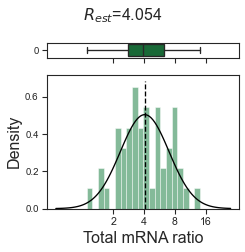

In [8]:
tm.infer.ratios_bc(adata_dbl_mg,
                  dblgroup='naive_active',
                  max_iter=30,
                  verbose=1,verbose_interval=2)

w_best = adata_dbl_mg.uns['ratio']['w_best']
tm.vis.logRatio_dist((1-w_best)/w_best)

Compare estimated total-mRNA ratios of each heterotypic doublet with ground truth

In [10]:
log2R_pred = np.log2((1-w_best)/w_best)
log2R_true = np.log2(adata.obs.loc[adata.obs['danno']=='naive_active','trueR'])

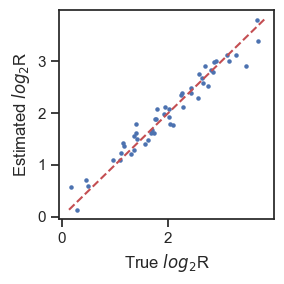

In [11]:
plt.figure(figsize=(3,3))
plt.scatter(log2R_true, log2R_pred,s=5)
plt.plot([np.min(log2R_pred),np.max(log2R_pred)],[np.min(log2R_pred),np.max(log2R_pred)],'--',c='r')
plt.xlabel('True $log_{2}$R',fontsize=12)
plt.ylabel('Estimated $log_{2}$R',fontsize=12)
plt.tight_layout()
plt.show()